In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DistilBertModel, DistilBertTokenizer, AutoModel

import os
import random
import shutil
import itertools
import numpy as np
from PIL import Image
from collections import Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
#-- Configuration settings ---
class CFG:
    image_path = "/kaggle/input/coco-animal-dataset"
    working_path = "/kaggle/working"
    coco_caption_path = "/kaggle/input/animal-captions/Coco"
    Animal_10_caption_path = "/kaggle/input/animal-captions/animal10"
    classes = ['bear', 'cat', 'cow', 'dog', 'elephant', 'zebra', 'horse', 'sheep', 'giraffe']
    seen_classes = classes[:7] 
    unseen_classes = classes[7:] 
    batch_size = 32
    num_workers = 2
    epochs = 20
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model choices
    image_embedding = 1000
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 300
    text_captionizer = "Salesforce/blip-image-captioning-base"
    
    # for projection head, used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 512
    dropout = 0.1

    # Training hyperparameters
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    head_lr = 1e-3
    weight_decay = 1e-3
    temperature = 1.0
    patience = 5
    factor = 0.8

    # Image transforms
    image_size = 224
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [3]:
# --- Dataset ---
class CocoDataset(Dataset):
    def __init__(self, root_dir, tokenizer, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([animal_dir for animal_dir in os.listdir(self.root_dir) if not animal_dir.endswith('.txt')])
        
        
        self.image_paths = []
        self.captions = []
        self.image_class = []
        self.image_caption_dict = {}
        

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            caption_dir = os.path.join(CFG.coco_caption_path, class_name+'.txt')

            with open(caption_dir, 'r') as file:
                for line in file:
                    parts = line.strip().split(',')
                    self.image_caption_dict[os.path.join(class_dir, parts[0])] = parts[1]

            self.image_paths = list(self.image_caption_dict.keys())
            
        self.encoded_captions = tokenizer(
            list(self.image_caption_dict.values()), padding=True, truncation=True, max_length=CFG.max_length
        )
                

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }
        
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
            
        item['image'] = image.float()
        item['caption'] = self.image_caption_dict[image_path]
        item['class'] = os.path.basename(os.path.dirname(image_path))
        
        return item

In [4]:
# --- Dataset ---
def get_datasets(tokenizer, data_dir=CFG.working_path, transform=CFG.preprocess):
    train_dataset = CocoDataset(os.path.join(data_dir, 'seen'), tokenizer, transform)
    test_dataset = CocoDataset(os.path.join(data_dir, 'unseen'), tokenizer, transform)
    return train_dataset, test_dataset

In [5]:
# --- Dataloader ---
def load_data(train_dataset, test_dataset, batch_size=32, num_workers=2, split_ratio=0.8):
    # Split 'seen' data into train and validation sets
    train_size = int(split_ratio * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

In [6]:
# --- Copying Images and descriptions ---
def copy_images_and_description(source_dir, destination_dir):
    seen_images_path = os.path.join(destination_dir, 'seen')
    unseen_images_path = os.path.join(destination_dir, 'unseen')

    os.makedirs(seen_images_path, exist_ok=True)
    os.makedirs(unseen_images_path, exist_ok=True)

    for dir_type, class_type in [('seen', CFG.seen_classes), ('unseen', CFG.unseen_classes)]:
        for animal_class in tqdm(class_type, desc=f'Copying {dir_type} classes'):
            create_class_directory(destination_dir, dir_type, animal_class)
            copy_description_file(source_dir, destination_dir, dir_type, animal_class)
            copy_image_files(source_dir, destination_dir, dir_type, animal_class)
            
def copy_image_files(source_dir, destination_dir, dir_type, animal_class):
    animal_class_source = os.path.join(source_dir, animal_class)
    animal_class_destination = os.path.join(destination_dir, dir_type, animal_class)

    for animal_image in tqdm(os.listdir(animal_class_source), desc=f'Copying {animal_class} images'):
        image_source = os.path.join(animal_class_source, animal_image)
        image_destination = os.path.join(animal_class_destination, animal_image)
        try:
            shutil.copyfile(image_source, image_destination)
        except FileNotFoundError:
            print(f"Image file {animal_image} not found for {animal_class}")

def copy_description_file(source_dir, destination_dir, dir_type, animal_class):
    description_source = os.path.join(source_dir, f'{animal_class}.txt')
    description_destination = os.path.join(destination_dir, dir_type, f'{animal_class}.txt')
    try:
        shutil.copyfile(description_source, description_destination)
    except FileNotFoundError:
        print(f"Description file not found for {animal_class}")
        
def create_class_directory(destination_dir, dir_type, animal_class):
    animal_class_destination = os.path.join(destination_dir, dir_type, animal_class)
    os.makedirs(animal_class_destination, exist_ok=True)

In [7]:
# --- Visualize random images ---
def visualize_random_images(dataset, num_images=3):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        # Select a random sample from the dataset
        idx = random.randint(0, len(dataset) - 1)
        item = dataset[idx]
        image = item['image']
        
        # Convert the image tensor to numpy array and transpose it
        image_np = image.permute(1, 2, 0).numpy()

        # Plot the image on the corresponding subplot
        axes[i].imshow(image_np)
        axes[i].set_title(f"Caption: {item['caption']}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
# --- Visualize training and validation losses over epochs ---
def show_plots(history):
    loss_vals = history['train_loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(loss_vals) + 1)

    plt.figure(figsize=(8, 4))
    plt.plot(epochs, loss_vals, color='navy', marker='o', linestyle='-', label='Training Loss')
    plt.plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [9]:
#--- Image Model --- 
class ImageEncoder(nn.Module):
    def __init__(self, trainable=True):
        super().__init__()
        self.model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        self.model.fc = nn.Identity() 
        
        for param in self.model.parameters():
            param.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [10]:
#--- Text Model --- 
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, trainable=True):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)

        for param in self.model.parameters():
            param.requires_grad = trainable

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask)
        return outputs.last_hidden_state[:, 0]

In [11]:
#--- Projection into the same dimension --- 
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [12]:
#--- Loss tracker --- 
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


In [13]:
#--- Zero Shot model--- 
class ZeroShotModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [14]:
#--- Train function ---
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, desc='Training', total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption" and k != 'class'}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter

In [15]:
#--- Validation function ---
def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, desc='Validation', total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption" and k != 'class'}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

In [16]:
copy_images_and_description(CFG.image_path, CFG.working_path)

Copying seen classes:   0%|          | 0/7 [00:00<?, ?it/s]

Copying bear images:   0%|          | 0/926 [00:00<?, ?it/s]

Copying cat images:   0%|          | 0/4041 [00:00<?, ?it/s]

Copying cow images:   0%|          | 0/1616 [00:00<?, ?it/s]

Copying dog images:   0%|          | 0/4117 [00:00<?, ?it/s]

Copying elephant images:   0%|          | 0/2043 [00:00<?, ?it/s]

Copying zebra images:   0%|          | 0/1724 [00:00<?, ?it/s]

Copying horse images:   0%|          | 0/2782 [00:00<?, ?it/s]

Copying unseen classes:   0%|          | 0/2 [00:00<?, ?it/s]

Copying sheep images:   0%|          | 0/1316 [00:00<?, ?it/s]

Copying giraffe images:   0%|          | 0/2187 [00:00<?, ?it/s]

In [17]:
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
train_dataset, test_dataset = get_datasets(tokenizer)
train_loader, val_loader, test_loader = load_data(train_dataset, test_dataset)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

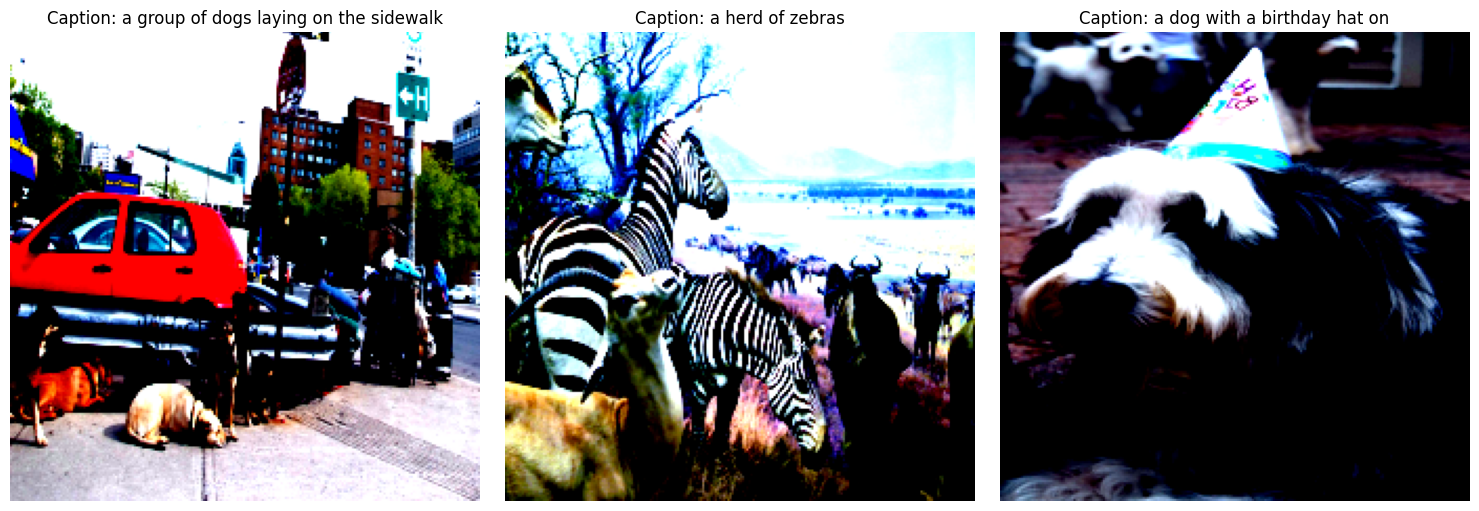

In [18]:
visualize_random_images(train_dataset)

In [19]:
model = ZeroShotModel().to(CFG.device)

params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 164MB/s]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [20]:
optimizer = torch.optim.AdamW(params, weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
)
step = "epoch"

In [21]:
best_loss = float('inf')
best_epoch = 0
no_improvement = 0
history = {'train_loss':[], 'val_loss': []} 

for epoch in tqdm(range(CFG.epochs), desc='Epoch'):
    model.train()
    train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
    history['train_loss'].append(train_loss.avg)
    model.eval()
    with torch.no_grad():
        valid_loss = valid_epoch(model, val_loader)
        history['val_loss'].append(valid_loss.avg)

    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        torch.save(model.state_dict(), "best.pt")
        no_improvement = 0
        best_epoch = epoch
        print("Saved Best Model!")
    else:
        no_improvement += 1
        
    if no_improvement >= CFG.patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

    lr_scheduler.step(valid_loss.avg)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Saved Best Model!


Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Saved Best Model!


Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Saved Best Model!


Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Saved Best Model!


Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Saved Best Model!


Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Saved Best Model!


Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Saved Best Model!


Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Saved Best Model!


Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Saved Best Model!


Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Saved Best Model!


Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/432 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Early stopping at epoch 17


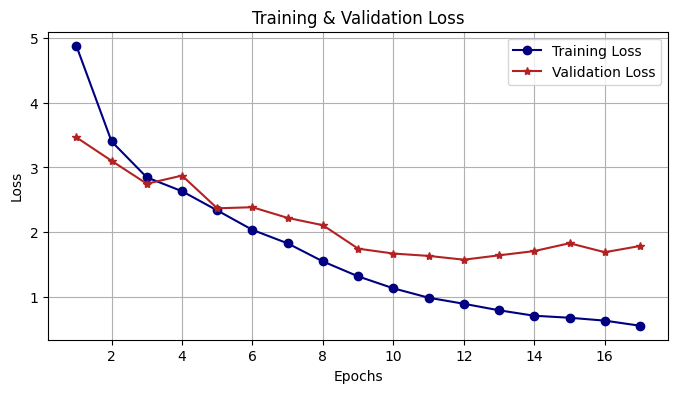

In [22]:
show_plots(history)

In [23]:
def load_best(model_path):
    model = ZeroShotModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    return model

In [24]:
model = load_best("best.pt")

In [25]:
def get_image_embeddings(model, test_loader):
    test_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            test_image_embeddings.append(image_embeddings)
    return torch.cat(test_image_embeddings)

In [26]:
image_embeddings = get_image_embeddings(model, test_loader)

  0%|          | 0/110 [00:00<?, ?it/s]

In [27]:
def find_matches(model, tokenizer, image_embeddings, query, image_filepaths, n=5, temperature=1.0):
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }

    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)

    # Temperature scaling
    logits = (text_embeddings_n @ image_embeddings_n.T) / temperature 
    dot_similarity = logits.squeeze(0)  

    values, indices = torch.topk(dot_similarity, n)

    matches = [image_filepaths[idx] for idx in indices]

    _, axes = plt.subplots(1, n, figsize=(5 * n, 5))  # Adjust figure size
    for match, ax, score in zip(matches, axes.flatten(), values):
        image = match['image']
        image_np = image.permute(1, 2, 0).numpy()
        ax.imshow(image_np)
        ax.set_title(f"Score: {score:.2f}")
        ax.axis("off")

    plt.show()

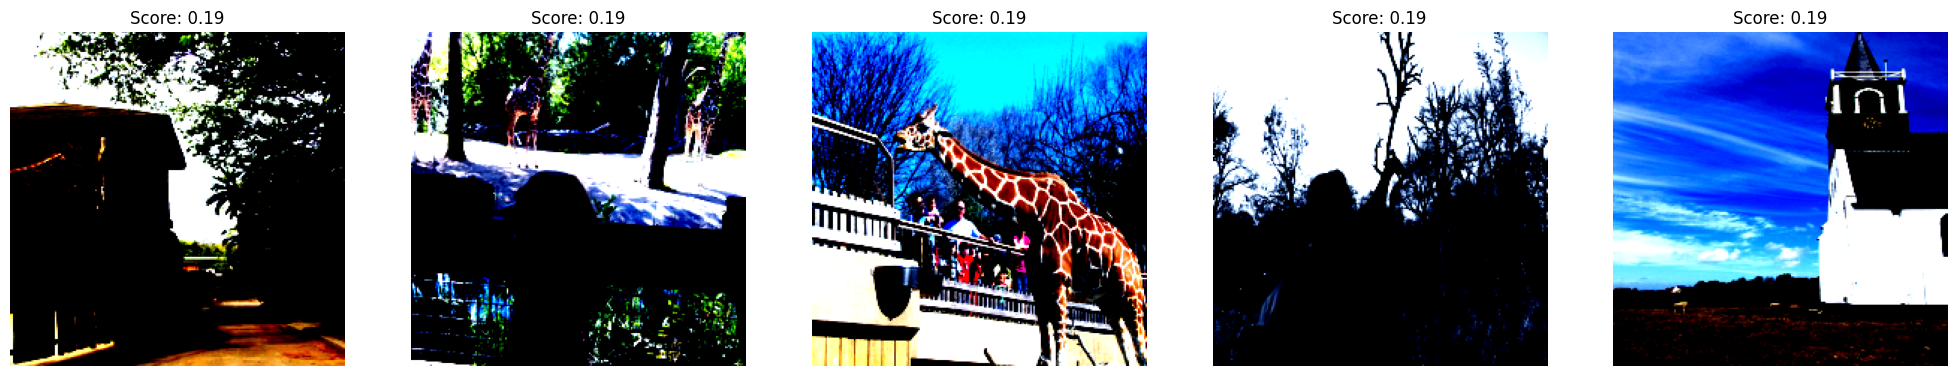

In [28]:
find_matches(model,
             tokenizer,
             image_embeddings,
             query="a photo of a squirel",
             image_filepaths=test_dataset)

In [29]:
def prepare_image(image):
    if isinstance(image, Image.Image):
        return CFG.preprocess(image).unsqueeze(0).to(CFG.device)
    elif image.ndim == 4:
        return image.to(CFG.device)
    else:
        return image.unsqueeze(0).to(CFG.device)

In [30]:
def construct_queries(classes=CFG.classes):
    queries = []
    base = 'a photo of a '
    for class_name in classes:
        queries.append(base + class_name)
    return queries

In [31]:
def predicate_query_image(model, image_text_pair, tokenizer, queries=construct_queries(), top_k=5):
    """
    Evaluates an image against a set of text queries and displays results.

    Args:
        model (ZeroShotModel): Your trained CLIP-like model.
        image (Tensor or PIL Image): The image to evaluate.
        queries (List[str]): A list of text queries.
        tokenizer (DistilBertTokenizer): Your DistilBERT tokenizer.
        top_k (int, optional): Number of top results to display. Defaults to 5.
    """
    image = image_text_pair['image']
    
    image = prepare_image(image)

    with torch.no_grad():
        # Encode image
        image_features = model.image_encoder(image)
        image_embeddings = model.image_projection(image_features)

    # Encode queries
    text_input = tokenizer(queries, padding="max_length", return_tensors="pt").to(CFG.device)
    text_features = model.text_encoder(**text_input)
    text_embeddings = model.text_projection(text_features)

    # Calculate similarities and probabilities
    logits = image_embeddings @ text_embeddings.T
    probs = logits.softmax(dim=-1).cpu().detach().numpy()

    # Find top-k results
    topk_probs, topk_indices = torch.topk(torch.tensor(probs[0]), top_k)  # Probabilities for a single image
    return topk_probs, topk_indices

In [32]:
def visualize_eval(image_text_pair, topk_probs, topk_indices, queries=construct_queries(), top_k=5):
    
    image = image_text_pair['image']
    image = prepare_image(image)
    
    correct_label = f"a photo of a {image_text_pair['class']}"
    
    # Display image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)  # Divide figure into 1 row, 2 columns, position 1
    plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy()) 
    plt.title("Input Image")
    plt.axis("off")

    # Display top results
    plt.subplot(1, 2, 2)
    
    # Get colors for bars 
    colors = []
    for i, idx in enumerate(topk_indices):
        if queries[idx] == correct_label:
            colors.append('orange' if topk_probs[i] != max(topk_probs) else 'green')
        elif i == 0:  # Check only the first bar for incorrect label
            colors.append('red')
        else:
            colors.append('lightgray')  # Or any other color you prefer for non-correct labels

    plt.barh(y=range(len(topk_indices)), width=topk_probs, color=colors, edgecolor='white')

    # Reduce x-axis ticks
    plt.xticks([0.2, 0.4, 0.6, 0.8, 1.0])

    # Remove y-ticks
    plt.yticks([])  

    # Invert bar order
    plt.gca().invert_yaxis()  

    plt.title(f"Top {top_k} Predictions")
    plt.xlabel("Probability")

    # Add query values as labels
    for i, (y_pos, prob) in enumerate(zip(range(len(topk_indices)), topk_probs)): 
        plt.text(prob + 0.01, y_pos, f"{queries[topk_indices[i].item()]} ({prob:.2f})", ha='left', va='center') 

    plt.tight_layout()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.show()

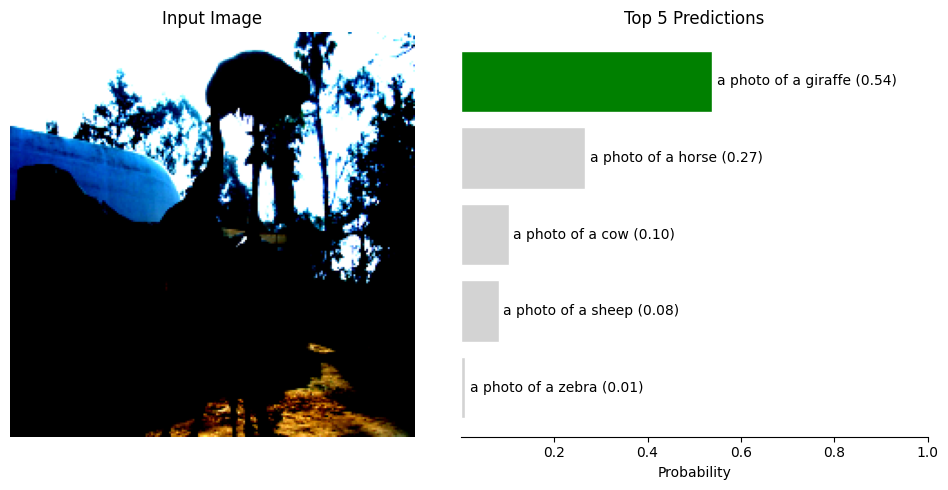

In [33]:
image = test_dataset[random.randint(0, len(test_dataset)-1)]
queries = construct_queries()
topk_probs, topk_indices = predicate_query_image(model, image, tokenizer)
visualize_eval(image, topk_probs, topk_indices)

In [34]:
def test(model, data_loader, queries):
    model.eval()

    correct = defaultdict(int)
    total = defaultdict(int)
    ranking = defaultdict(list)
    classes = set()
    certainty = defaultdict(float)
    
    text_input = tokenizer(queries, padding="max_length", return_tensors="pt").to(CFG.device)
    text_features = model.text_encoder(**text_input)
    text_embeddings = model.text_projection(text_features)

    with torch.no_grad():
        for batch in tqdm(data_loader):
            classes.update(batch['class'])
            
            with torch.no_grad():
                # Encode image
                image_features = model.image_encoder(batch['image'].to(CFG.device))
                image_embeddings = model.image_projection(image_features)
                
            # Calculate similarities and probabilities
            logits = image_embeddings @ text_embeddings.T
            probs = logits.softmax(dim=-1)

            # Find top results
            top_probs, top_indices = torch.max(probs, dim=1)

            # Update accuracy metrics and certainty
            for idx, label in enumerate(batch['class']):
                correct_query = f"a photo of a {label}"  # Construct correct query for each item
                total[label] += 1
                
                # Get ranking position
                ranking_position = (probs[idx].argsort(descending=True) == queries.index(correct_query)).nonzero().item() + 1
                ranking[label].append(ranking_position)
                
                if queries[top_indices[idx].item()] == correct_query:  # Check top-1 prediction
                    correct[label] += 1 
                    certainty[label] += top_probs[idx].item() 

    # Calculate accuracy and certainty
    accuracy = {k: correct[k] / total[k] for k in total.keys()}
    for class_name in classes:
        certainty[class_name] /= correct[class_name] if correct[class_name] != 0 else 1

    # Print results
    print('Accuracy and certainty for ')
    for class_name in classes: 
        print(f"\t{class_name:<10}: Accuracy={accuracy.get(class_name, 0.0)*100:.0f}%, Certainty={certainty.get(class_name, 0.0)*100:.0f}%")
    
    print('Distribution of ranking for ')
    for class_name in ranking:
        print(f'\t{class_name}:')
        counter = Counter(ranking[class_name])
        most_common = counter.most_common(1)[0][0]
        avg_rankings = sum(ranking[class_name]) / len(ranking[class_name])
        print(f'\t\tMost common ranking: {most_common}')
        print(f'\t\tAverage ranking    : {avg_rankings}')
        
    mean_accuracy = sum(accuracy.values()) / len(accuracy) 
    print(f'\nMean accuracy :{mean_accuracy*100:.0f}%')

In [35]:
# unseen data test
test(model, test_loader, queries)

  0%|          | 0/110 [00:00<?, ?it/s]

Accuracy and certainty for 
	sheep     : Accuracy=51%, Certainty=75%
	giraffe   : Accuracy=46%, Certainty=65%
Distribution of ranking for 
	giraffe:
		Most common ranking: 1
		Average ranking    : 1.9236396890717877
	sheep:
		Most common ranking: 1
		Average ranking    : 1.9924012158054711

Mean accuracy :48%


In [36]:
# seen data test
test(model, train_loader, queries)

  0%|          | 0/432 [00:00<?, ?it/s]

Accuracy and certainty for 
	horse     : Accuracy=66%, Certainty=89%
	elephant  : Accuracy=64%, Certainty=85%
	bear      : Accuracy=90%, Certainty=93%
	dog       : Accuracy=51%, Certainty=83%
	cat       : Accuracy=86%, Certainty=96%
	cow       : Accuracy=23%, Certainty=62%
	zebra     : Accuracy=95%, Certainty=97%
Distribution of ranking for 
	dog:
		Most common ranking: 1
		Average ranking    : 2.2714849681141818
	elephant:
		Most common ranking: 1
		Average ranking    : 1.9246448424953675
	horse:
		Most common ranking: 1
		Average ranking    : 1.769823289533303
	cat:
		Most common ranking: 1
		Average ranking    : 1.3610341643582642
	cow:
		Most common ranking: 2
		Average ranking    : 2.5619707467282526
	bear:
		Most common ranking: 1
		Average ranking    : 1.2210526315789474
	zebra:
		Most common ranking: 1
		Average ranking    : 1.1661807580174928

Mean accuracy :68%


In [37]:
# Animal10 data test
class Animal10Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([animal_dir for animal_dir in os.listdir(self.root_dir)])
        self.translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken",
                 "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "ragno": "spider"}

        self.image_paths = []
        self.captions = []
        self.image_class = []
        self.image_caption_dict = {}
        
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            caption_dir = os.path.join(CFG.Animal_10_caption_path, self.translate[class_name]+'.txt')

            with open(caption_dir, 'r') as file:
                for line in file:
                    parts = line.strip().split(',')
                    self.image_caption_dict[os.path.join(class_dir, parts[0])] = parts[1]

            self.image_paths = list(self.image_caption_dict.keys())
            

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        item = {}
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        item['image'] = image.float()
        item['class'] = self.translate[os.path.basename(os.path.dirname(image_path))]
        
        return item
    
animal10_seen_dataset = Animal10Dataset('/kaggle/input/animals10/raw-img', CFG.preprocess)
animal10_seen_dataloader = DataLoader(animal10_seen_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

test(model, animal10_seen_dataloader, construct_queries(animal10_seen_dataset.translate.values()))

  0%|          | 0/757 [00:00<?, ?it/s]

Accuracy and certainty for 
	horse     : Accuracy=68%, Certainty=84%
	elephant  : Accuracy=71%, Certainty=88%
	dog       : Accuracy=52%, Certainty=83%
	butterfly : Accuracy=2%, Certainty=55%
	cat       : Accuracy=85%, Certainty=94%
	cow       : Accuracy=43%, Certainty=61%
	sheep     : Accuracy=48%, Certainty=72%
	spider    : Accuracy=16%, Certainty=64%
	chicken   : Accuracy=10%, Certainty=60%
	squirrel  : Accuracy=70%, Certainty=85%
Distribution of ranking for 
	dog:
		Most common ranking: 1
		Average ranking    : 2.313386798272671
	horse:
		Most common ranking: 1
		Average ranking    : 1.7792603888677088
	elephant:
		Most common ranking: 1
		Average ranking    : 2.025949953660797
	butterfly:
		Most common ranking: 6
		Average ranking    : 5.218181818181818
	chicken:
		Most common ranking: 4
		Average ranking    : 4.0229180116204
	cat:
		Most common ranking: 1
		Average ranking    : 1.3211083944580277
	cow:
		Most common ranking: 1
		Average ranking    : 1.8735262593783495
	sheep:
		Mo